# Unaware of Regression Discontinuities
Julian Hsu
28-july-2023

The purpose of this script is to show how biased estimates can be when data follows a regression discontinuity design (RDD) setting. That is, trying to use "all the data" rather than narrow on where the natural experiment takes place leads to bias.

Note that using all the data and using an RDD equation is global RD regression.

Explore how this scales if your data has multiple RDDs in it.


**Sound Byte:** Blindly using all your data is not a good idea. Regression discontinuity (RD) is a cool causal analysis that focuses analysis on units who have values that just manage to place them into the treatment group. Common examples are scoring just high enough to be placed into a class and elections around the 50% cutoff.

I show that there are biases from using all the data for estimation, regardless of whether you use OLS to DML models. Once you understand the data, it's better to model the narrow band around the cutoff than using a complicated model with all the data. Check out the notebook here (link), where find that while the DML estimates using all the data are close, they are very imprecise. I also investigate how this changes when there are multiple cutoffs (it doesn't).  

If you are interested in learning how to do RD with multiple cutoffs, I recommend this Cattaneo et. al (2016) paper (https://rdpackages.github.io/references/Cattaneo-Keele-Titiunik-VazquezBare_2016_JOP.pdf)  and their package for estimating regression discontinuity at multiple cutoffs (https://collaborate.princeton.edu/en/publications/analysis-of-regression-discontinuity-designs-with-multiple-cutoff). 

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict


## DGP Functions
Treatment status needs to vary over `x` , and we allow some noise in treatment assignment based on the cutoff.

In [3]:
def dgp(N=1000, rdd=1, gt=1):
    df=pd.DataFrame(data={'y':np.random.normal(0,0.25,N)})
    for r in range(rdd):
        df['x{0}'.format(r)] = np.random.uniform(-1,1,N)
        df['x{0}_rd'.format(r)] = (df['x{0}'.format(r)] > 0).astype(float)
        df['x{0}_rd_x'.format(r)] =  df['x{0}'.format(r)]*df['x{0}_rd'.format(r)]
        
        ## Treatment assignment
        w = ( df['x{0}'.format(r)] > 0).astype(float)
        
        ## Linear function of x
        ## Non-linear function of x
        df['y'] += np.sin(3*df['x{0}'.format(r)])
        df['y'] -= 2*np.log(2+df['x{0}'.format(r)])        
        ## A
        df['y'] += gt*w
    ## Create an aggregated treatment indicator
    df['w']=0
    for r in range(rdd):    
        df.loc[df['x{0}_rd'.format(r)]==1, 'w']=1
    return df

In [4]:
# model_y=Ridge(alpha=1, fit_intercept=True)
# model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True)
# cross_val_predict(model_t, np.array(df['x0']).reshape(-1,1), df['w'], cv=3
#                  ,method='predict_proba')[:,1]

In [29]:
## OLS regression approach
def ols_rd(data=None, x_list=None):
    X = sm.add_constant(data[x_list])
    model = sm.OLS(data['y'],X).fit()
    return model

## DML implementation
def dml_simple(data=None,X_list=None, w='w'
                , model_y=Ridge(alpha=1, fit_intercept=True)
                , model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True)):
    
    if len(X_list)==1:
        XX = np.array(df[X_list]).reshape(-1,1)
    else:
        XX = df[X_list].values
    yhat=cross_val_predict(model_y, X=XX, y= df['y'], cv=3)
    YM = data['y'] - yhat
    
    what=cross_val_predict(model_t, X=XX, y=df[w], cv=3,method='predict_proba')[:,1]
    data['wd']=what
    W = data[w].astype(float) - data['wd']

    ols_model_r = sm.OLS( YM, sm.add_constant(W)  ).fit()
    return ols_model_r.params.iloc[-1],ols_model_r.bse.iloc[-1]




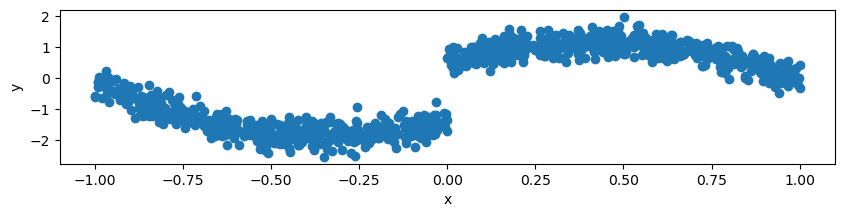

In [27]:
df = dgp(gt=2)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,2))
ax.scatter(df['x0'], df['y'])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()



## Simulation with one feature and cutoff

In [82]:
gt_ = 1
sim_total = 100

df_sim = pd.DataFrame()
for s in range(sim_total):
    df = dgp(gt=gt_)
    rdd_est=ols_rd(data=df, x_list=['x0','x0_rd']).params['x0_rd']
    rdd_se=ols_rd(data=df, x_list=['x0','x0_rd']).bse['x0_rd']

    rdd_est_dml = dml_simple(data=df,X_list=['x0']
                            ,model_y=RandomForestRegressor(n_estimators=50,n_jobs=-1)
                            ,model_t=RandomForestClassifier(n_estimators=50,n_jobs=-1))
    
    rdd_est_band = ols_rd(data=df.loc[df['x0'].between(-0.15,0.15)]
                          , x_list=['x0','x0_rd','x0_rd_x']).params['x0_rd']
    rdd_se_band = ols_rd(data=df.loc[df['x0'].between(-0.15,0.15)]
                          , x_list=['x0','x0_rd','x0_rd_x']).bse['x0_rd']

    
    entry = pd.DataFrame(index=[s],data={'all data':rdd_est, 'all data se':rdd_se
                            ,'all dml data':rdd_est_dml[0],'all dml data se':rdd_est_dml[1]
                            ,'bandwidth data':rdd_est_band,'bandwidth data se':rdd_se_band
                              ,'gt':gt_})
    entry['all diff'] = entry['all data'] - entry['gt']
    entry['all dml diff'] = entry['all dml data'] - entry['gt']
    entry['bandwidth diff'] = entry['bandwidth data'] - entry['gt']
    df_sim = pd.concat([df_sim, entry])

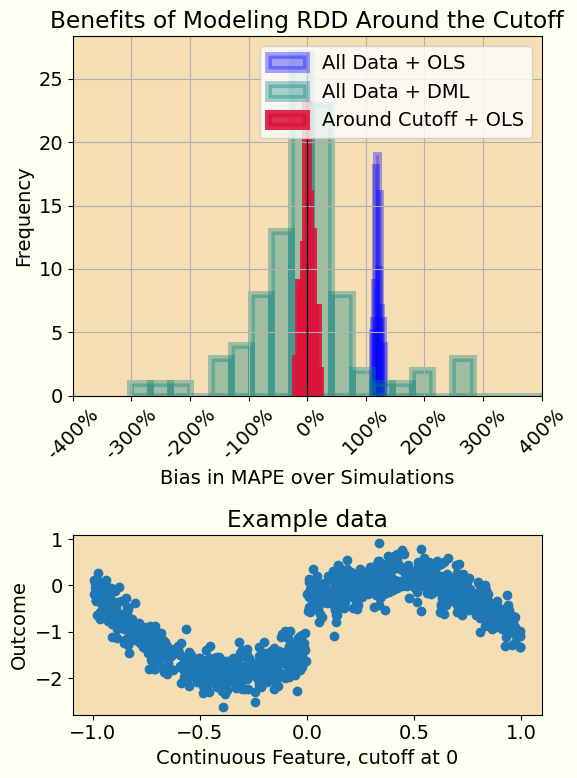

In [83]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,8)
                    ,  gridspec_kw={'height_ratios': [4, 2]}) 
ax1 = ax[0].hist(df_sim['all diff']
              , label='All Data + OLS'
              , color='blue', alpha=0.35              
              , linewidth=5
              , edgecolor='blue') 
ax2 = ax[0].hist(df_sim['all dml diff']
              ,bins=45, label='All Data + DML'
              , color='teal', alpha=0.35              
              , linewidth=5
              , edgecolor='teal') 
ax3 = ax[0].hist(df_sim['bandwidth diff']
              , label='Around Cutoff + OLS'
              , color='crimson', alpha=0.90
              , linewidth=5
              , edgecolor='crimson')               
ax[0].plot([0,0]
        ,[0,np.max(  np.concatenate((ax1[0],ax2[0],ax3[0]) )  )]
        ,linewidth=1, color='black')
ax[0].legend()
ax[0].grid()
ax[0].set_facecolor('wheat')

ax[0].set_xlabel('Bias in MAPE over Simulations')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Benefits of Modeling RDD Around the Cutoff')
ax[0].set_xticks(np.arange(-4,4.1,1))
ax[0].set_xticklabels(['{0:3.0f}%'.format(e*100) for e in np.arange(-4,4.1,1)]
                     , rotation=45)
ax[0].set_xlim([-4,4])

ax[1].scatter(df['x0'], df['y'])
ax[1].set_xlabel('Continuous Feature, cutoff at 0')
ax[1].set_ylabel('Outcome')

ax[1].set_facecolor('wheat')
ax[1].set_title('Example data')


fig.set_facecolor('ivory')
plt.tight_layout()
plt.show()


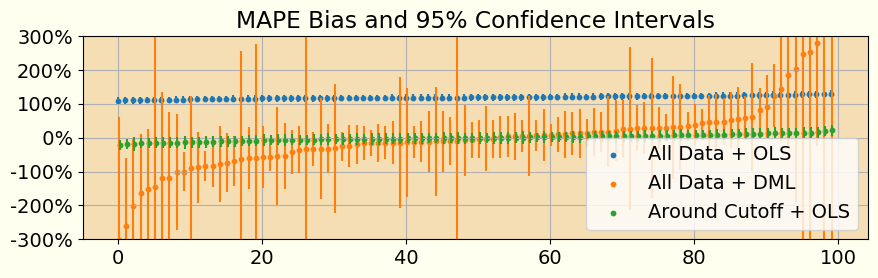

In [93]:

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(9,3))
i = 0
xlist = ['All Data + OLS', 'All Data + DML', 'Around Cutoff + OLS']
for e in ['all data','all dml data','bandwidth data']:
    plot_ = df_sim.sort_values(by=e, ascending=True)[[e,e+' se']]
    plot_['lower'] = plot_[e]-1.96*plot_[e+' se']-1
    plot_['upper'] = plot_[e]+1.96*plot_[e+' se']-1
    x = np.arange(len(df_sim))+0.10*i
    xj=ax.scatter(x, plot_[e]-1, label=xlist[i], s=10)
    ax.vlines(x=x, ymin=plot_['lower']
                , ymax=plot_['upper']
                 , color=xj.get_facecolor())
    i+=1
ax.grid()
ax.legend()
ax.set_yticks(np.arange(-3,3.1,1))
ax.set_yticklabels(['{0:3.0f}%'.format(e*100) for e in np.arange(-3,3.1,1)]
                     , rotation=0)

ax.set_ylim([-3,3])

ax.set_facecolor('wheat')
ax.set_title('MAPE Bias and 95% Confidence Intervals')

fig.set_facecolor('ivory')
plt.tight_layout()
plt.show()


## Simulation with two features and cutoff

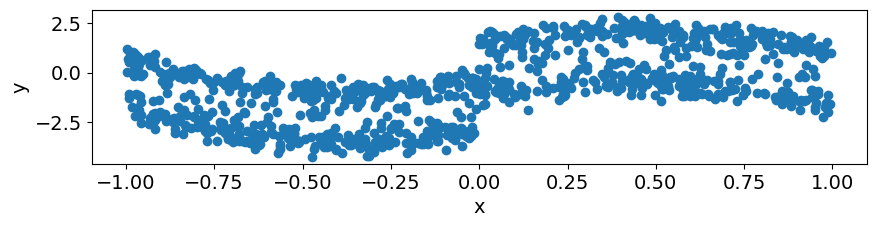

In [94]:
df = dgp(gt=2, rdd=2)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,2))
ax.scatter(df['x0'], df['y'])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()



In [95]:
gt_ = 1
sim_total = 100

df_sim = pd.DataFrame()
for s in range(sim_total):
    df = dgp(gt=gt_, rdd=2)

    rdd_est=ols_rd(data=df, x_list=['x0','x0_rd']).params['x0_rd']
    rdd_se=ols_rd(data=df, x_list=['x0','x0_rd']).bse['x0_rd']

    rdd_est_dml = dml_simple(data=df,X_list=['x0']
                            ,model_y=RandomForestRegressor(n_estimators=50,n_jobs=-1)
                            ,model_t=RandomForestClassifier(n_estimators=50,n_jobs=-1))
    
    rdd_est_band = ols_rd(data=df.loc[df['x0'].between(-0.15,0.15)]
                          , x_list=['x0','x0_rd','x0_rd_x']).params['x0_rd']
    rdd_se_band = ols_rd(data=df.loc[df['x0'].between(-0.15,0.15)]
                          , x_list=['x0','x0_rd','x0_rd_x']).bse['x0_rd']

    
    entry = pd.DataFrame(index=[s],data={'all data':rdd_est, 'all data se':rdd_se
                            ,'all dml data':rdd_est_dml[0],'all dml data se':rdd_est_dml[1]
                            ,'bandwidth data':rdd_est_band,'bandwidth data se':rdd_se_band
                              ,'gt':gt_})
    entry['all diff'] = entry['all data'] - entry['gt']
    entry['all dml diff'] = entry['all dml data'] - entry['gt']
    entry['bandwidth diff'] = entry['bandwidth data'] - entry['gt']
    df_sim = pd.concat([df_sim, entry])
    

Exception in thread Thread-8615:
Traceback (most recent call last):
  File "C:\Users\tarob\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\tarob\anaconda3\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\tarob\anaconda3\lib\multiprocessing\pool.py", line 592, in _handle_results
    cache[job]._set(i, obj)
  File "C:\Users\tarob\anaconda3\lib\multiprocessing\pool.py", line 776, in _set
    self._callback(self._value)
  File "C:\Users\tarob\anaconda3\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\tarob\anaconda3\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\tarob\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\tarob\anaconda3\lib\site-packages\joblib\parallel.py

KeyboardInterrupt: 

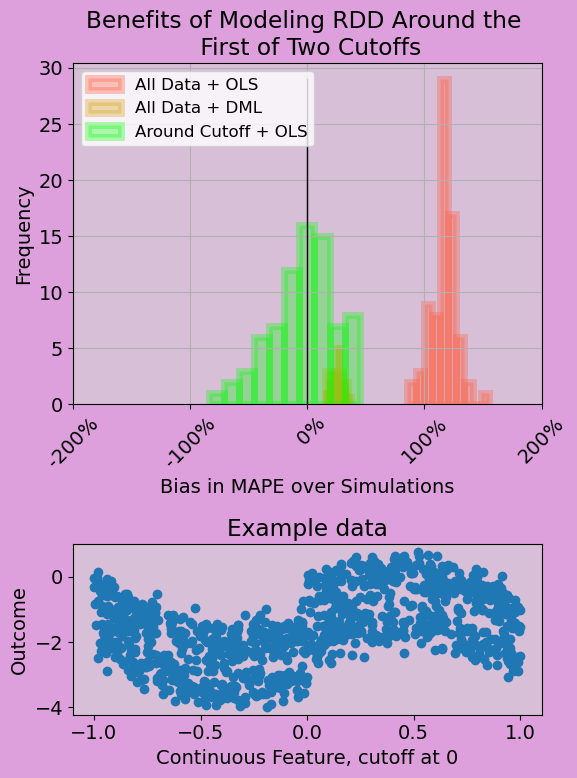

In [96]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,8)
                    ,  gridspec_kw={'height_ratios': [4, 2]}) 
ax1 = ax[0].hist(df_sim['all diff']
              , label='All Data + OLS'
              , color='tomato', alpha=0.35              
              , linewidth=5
              , edgecolor='tomato') 
ax2 = ax[0].hist(df_sim['all dml diff']
              ,bins=45, label='All Data + DML'
              , color='goldenrod', alpha=0.35              
              , linewidth=5
              , edgecolor='goldenrod') 
ax3 = ax[0].hist(df_sim['bandwidth diff']
              , label='Around Cutoff + OLS'
              , color='lime', alpha=0.30
              , linewidth=5
              , edgecolor='lime')               
ax[0].plot([0,0]
        ,[0,np.max(  np.concatenate((ax1[0],ax2[0],ax3[0]) )  )]
        ,linewidth=1, color='black')
ax[0].legend(fontsize=12)
ax[0].grid()
ax[0].set_facecolor('thistle')

ax[0].set_xlabel('Bias in MAPE over Simulations')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Benefits of Modeling RDD Around the \n First of Two Cutoffs')
ax[0].set_xticks(np.arange(-2,2.1,1))
ax[0].set_xticklabels(['{0:3.0f}%'.format(e*100) for e in np.arange(-2,2.1,1)]
                     , rotation=45)
ax[0].set_xlim([-2,2])

ax[1].scatter(df['x0'], df['y'])
ax[1].set_xlabel('Continuous Feature, cutoff at 0')
ax[1].set_ylabel('Outcome')

ax[1].set_facecolor('thistle')
ax[1].set_title('Example data')


fig.set_facecolor('plum')
plt.tight_layout()
plt.show()
